# 2.6 Boiler Fouling Dataset EDA - Fouling-Corrected Simulation

**Date:** September 3, 2025  
**Analyst:** JDG  
**Dataset:** Massachusetts Boiler Annual Simulation (Fouling-Corrected)  
**Status:** 🎯 **CALIBRATED EFFECTIVENESS VALIDATION**

## Objective

Analysis of the calibrated boiler simulation system with optimized soot blowing effectiveness targeting 90-95% cleaning performance for realistic commercial demo applications.

### Calibrations Applied:
1. ✅ **Effectiveness Range**: Updated to 88-97% parameter range
2. ✅ **File Path Organization**: Outputs to project root directories
3. ✅ **Realistic Performance**: Targeting 90-95% average effectiveness
4. ✅ **Commercial Demo Ready**: Balanced performance degradation

### Expected Outcomes:
- Cleaning effectiveness: 88-92% average (target 90-95% range)
- Realistic industrial performance variation
- Proper fouling accumulation and cleaning reset patterns
- Maintained physics validation (time-fouling correlation >+0.4)
- System efficiency impacts from fouling and cleaning events

In [1]:
# Standard data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
import warnings
import sys
import os
warnings.filterwarnings('ignore')

# Add path to our comprehensive analysis module
module_path = os.path.join('..', 'src', 'models', 'complete_boiler_simulation', 'analysis')
if module_path not in sys.path:
    sys.path.append(module_path)

# Import comprehensive analysis functions
try:
    from boiler_eda_analysis import (
        analyze_operational_performance,
        analyze_soot_blowing_patterns,
        analyze_fouling_patterns,
        analyze_cleaning_effectiveness,
        analyze_cleaning_schedule_optimization,
        analyze_coal_quality_impact,
        analyze_seasonal_patterns,
        create_comprehensive_visualizations,
        run_comprehensive_analysis,
        generate_optimization_recommendations
    )
    print("✅ Comprehensive analysis functions imported successfully")
except ImportError as e:
    print(f"⚠️ Could not import analysis functions: {e}")
    print("   Falling back to basic analysis")

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("✅ Libraries imported successfully")
print(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Comprehensive analysis functions imported successfully
✅ Libraries imported successfully
Analysis Date: 2025-09-03 15:41:14


In [2]:
# Load the fouling-corrected calibrated dataset
dataset_path = '../data/generated/annual_datasets/massachusetts_boiler_annual_20250903_115813.csv'

try:
    df = pd.read_csv(dataset_path)
    print(f"✅ Calibrated dataset loaded successfully")
    print(f"   Records: {len(df):,}")
    print(f"   Features: {len(df.columns)}")
    print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    print(f"   Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    
    # Convert timestamp
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Store original shape for later comparison
    original_shape = df.shape
    
    # Column analysis for section-specific soot blowing
    cleaning_cols = [col for col in df.columns if 'cleaning' in col.lower()]
    fouling_cols = [col for col in df.columns if 'fouling' in col.lower()]
    
    print(f"\n📊 Calibrated Dataset Features:")
    print(f"   Section-specific cleaning columns: {len(cleaning_cols)}")
    print(f"   Fouling monitoring columns: {len(fouling_cols)}")
    
    if cleaning_cols:
        print(f"\n🧹 Section-Specific Cleaning Columns:")
        for i, col in enumerate(cleaning_cols[:7], 1):
            events = df[col].sum()
            freq = df[col].mean()
            section = col.replace('_cleaning', '').replace('_', ' ').title()
            print(f"   {i}. {section}: {events} events ({freq:.1%} frequency)")
        if len(cleaning_cols) > 7:
            print(f"   ... and {len(cleaning_cols)-7} more sections")
    
except Exception as e:
    print(f"❌ Error loading calibrated dataset: {e}")
    raise

✅ Calibrated dataset loaded successfully
   Records: 8,784
   Features: 220
   Memory usage: 15.5 MB
   Date range: 2024-01-01 00:00:00 to 2024-12-31 23:00:00

📊 Calibrated Dataset Features:
   Section-specific cleaning columns: 9
   Fouling monitoring columns: 49

🧹 Section-Specific Cleaning Columns:
   1. Avg Effectiveness: 261.67885496775136 events (3.0% frequency)
   2. Furnace Walls: 121 events (1.4% frequency)
   3. Generating Bank: 182 events (2.1% frequency)
   4. Superheater Primary: 91 events (1.0% frequency)
   5. Superheater Secondary: 73 events (0.8% frequency)
   6. Economizer Primary: 52 events (0.6% frequency)
   7. Economizer Secondary: 36 events (0.4% frequency)
   ... and 2 more sections


## 🎯 CRITICAL PHYSICS VALIDATION

### Target Metrics (from Previous Analysis):
- **Time-Fouling Correlation**: Target >+0.4 (was ~0.01)
- **Efficiency-Fouling Correlation**: Target <-0.25 (was +0.12)  
- **Load Factor Range**: 60-105% (was 0% compliance)
- **Parameter Variation**: Realistic variation (was 13 constant columns)
- **Soot Blowing Effectiveness**: 80-95% fouling reduction target

### Physics Corrections Applied:
1. Fixed efficiency-fouling correlation calculation
2. Implemented time-based fouling accumulation (time since cleaning)
3. Added CEMS stack temperature correlations
4. Removed combustion_model dependency for parameter variation
5. Enhanced soot blowing effectiveness modeling

In [3]:
# CALIBRATION VALIDATION ANALYSIS
print("=" * 80)
print("🎯 CALIBRATION VALIDATION RESULTS")
print("=" * 80)

# Find section-specific cleaning and fouling columns
section_names = [
    'furnace_walls', 'generating_bank', 'superheater_primary', 'superheater_secondary',
    'economizer_primary', 'economizer_secondary', 'air_heater'
]

calibration_results = {}
effectiveness_values = []

print(f"\n🧹 SECTION-SPECIFIC CLEANING EFFECTIVENESS:")

for section in section_names:
    cleaning_col = f"{section}_cleaning"
    fouling_col = f"{section}_fouling_factor"
    
    if cleaning_col in df.columns and fouling_col in df.columns:
        # Find cleaning events
        cleaning_events = df[df[cleaning_col] == 1].copy()
        
        if len(cleaning_events) > 0:
            section_effectiveness = []
            
            # Analyze effectiveness for each cleaning event
            for idx in cleaning_events.index:
                if idx > 0 and idx < len(df) - 1:
                    before = df.loc[idx - 1, fouling_col]
                    after = df.loc[idx + 1, fouling_col]
                    
                    if before > 1.0 and after < before:
                        effectiveness = (before - after) / (before - 1.0)
                        if 0.0 <= effectiveness <= 1.0:  # Sanity check
                            section_effectiveness.append(effectiveness)
                            effectiveness_values.append(effectiveness)
            
            if section_effectiveness:
                avg_eff = np.mean(section_effectiveness)
                std_eff = np.std(section_effectiveness)
                min_eff = np.min(section_effectiveness)
                max_eff = np.max(section_effectiveness)
                
                # Status assessment
                if 0.90 <= avg_eff <= 0.95:
                    status = "✅ TARGET ACHIEVED"
                elif 0.85 <= avg_eff < 0.90:
                    status = "⚠️ CLOSE TO TARGET"
                elif avg_eff >= 0.80:
                    status = "⚠️ ACCEPTABLE"
                else:
                    status = "❌ BELOW TARGET"
                
                section_name = section.replace('_', ' ').title()
                print(f"\n   {section_name}:")
                print(f"     Average effectiveness: {avg_eff:.1%} ± {std_eff:.1%} {status}")
                print(f"     Range: {min_eff:.1%} to {max_eff:.1%}")
                print(f"     Events analyzed: {len(section_effectiveness)}/{len(cleaning_events)}")
                
                calibration_results[section] = {
                    'avg_effectiveness': avg_eff,
                    'std_effectiveness': std_eff,
                    'events': len(section_effectiveness),
                    'in_target': 0.90 <= avg_eff <= 0.95
                }

# Overall calibration assessment
if effectiveness_values:
    overall_avg = np.mean(effectiveness_values)
    overall_std = np.std(effectiveness_values)
    overall_min = np.min(effectiveness_values)
    overall_max = np.max(effectiveness_values)
    
    print(f"\n" + "=" * 60)
    print(f"📊 OVERALL CALIBRATION RESULTS:")
    print(f"   Total events analyzed: {len(effectiveness_values)}")
    print(f"   Average effectiveness: {overall_avg:.1%} ± {overall_std:.1%}")
    print(f"   Range: {overall_min:.1%} to {overall_max:.1%}")
    print(f"   Target: 90-95% average effectiveness")
    
    # Calibration success assessment
    if 0.90 <= overall_avg <= 0.95:
        calibration_status = "✅ CALIBRATION HIGHLY SUCCESSFUL"
        calibration_grade = "A"
    elif 0.85 <= overall_avg < 0.90:
        calibration_status = "⚠️ CALIBRATION CLOSE TO TARGET"
        calibration_grade = "B+"
    elif overall_avg >= 0.80:
        calibration_status = "⚠️ CALIBRATION ACCEPTABLE"
        calibration_grade = "B"
    else:
        calibration_status = "❌ CALIBRATION NEEDS IMPROVEMENT"
        calibration_grade = "C"
    
    print(f"   Status: {calibration_status}")
    print(f"   Grade: {calibration_grade}")
    
    # Sections in target range
    sections_in_target = sum(1 for r in calibration_results.values() if r['in_target'])
    total_sections = len(calibration_results)
    target_percentage = sections_in_target / total_sections * 100 if total_sections > 0 else 0
    
    print(f"   Sections in target range: {sections_in_target}/{total_sections} ({target_percentage:.1f}%)")
    
else:
    print(f"\n❌ No cleaning effectiveness events found for calibration validation")
    calibration_status = "❌ CALIBRATION DATA MISSING"

🎯 CALIBRATION VALIDATION RESULTS

🧹 SECTION-SPECIFIC CLEANING EFFECTIVENESS:

   Generating Bank:
     Average effectiveness: 85.5% ± 21.0% ⚠️ CLOSE TO TARGET
     Range: 2.5% to 100.0%
     Events analyzed: 181/182

   Air Heater:
     Average effectiveness: 99.4% ± 0.7% ⚠️ ACCEPTABLE
     Range: 97.8% to 100.0%
     Events analyzed: 26/26

📊 OVERALL CALIBRATION RESULTS:
   Total events analyzed: 207
   Average effectiveness: 87.2% ± 20.2%
   Range: 2.5% to 100.0%
   Target: 90-95% average effectiveness
   Status: ⚠️ CALIBRATION CLOSE TO TARGET
   Grade: B+
   Sections in target range: 0/2 (0.0%)


In [4]:
# CRITICAL PHYSICS VALIDATION TESTS
print("=" * 80)
print("🎯 CRITICAL PHYSICS VALIDATION RESULTS")
print("=" * 80)

# Find main fouling column
fouling_cols = [col for col in df.columns if 'fouling' in col.lower()]
main_fouling_col = fouling_cols[0] if fouling_cols else None

validation_results = {}

if main_fouling_col:
    print(f"Using fouling column: {main_fouling_col}")
    
    # Create time index for correlation
    time_index = range(len(df))
    
    # TEST 1: Time-Fouling Correlation
    fouling_values = df[main_fouling_col]
    corr_time_fouling, p_val_tf = pearsonr(time_index, fouling_values)
    
    print(f"\n1️⃣ TIME-FOULING CORRELATION:")
    print(f"   Correlation: {corr_time_fouling:+.3f}")
    print(f"   Target: >+0.400")
    status1 = corr_time_fouling > 0.4
    print(f"   Status: {'✅ EXCELLENT' if status1 else '❌ NEEDS IMPROVEMENT'}")
    print(f"   P-value: {p_val_tf:.2e}")
    print(f"   Fouling Range: {fouling_values.min():.3f} to {fouling_values.max():.3f}")
    validation_results['time_fouling_corr'] = corr_time_fouling
    
    # TEST 2: Efficiency-Fouling Correlation  
    efficiency = df['system_efficiency']
    corr_fouling_eff, p_val_fe = pearsonr(fouling_values, efficiency)
    
    print(f"\n2️⃣ FOULING-EFFICIENCY CORRELATION:")
    print(f"   Correlation: {corr_fouling_eff:+.3f}")
    print(f"   Target: <-0.250")
    status2 = corr_fouling_eff < -0.25
    print(f"   Status: {'✅ EXCELLENT' if status2 else '❌ NEEDS IMPROVEMENT'}")
    print(f"   P-value: {p_val_fe:.2e}")
    print(f"   Efficiency Range: {efficiency.min():.3f} to {efficiency.max():.3f}")
    validation_results['fouling_eff_corr'] = corr_fouling_eff
    
    # TEST 3: Load Factor Range Compliance
    load_min, load_max = df['load_factor'].min(), df['load_factor'].max()
    load_in_range = ((df['load_factor'] >= 0.60) & (df['load_factor'] <= 1.05)).sum()
    load_compliance = (load_in_range / len(df)) * 100
    
    print(f"\n3️⃣ LOAD FACTOR COMPLIANCE:")
    print(f"   Range: {load_min:.1%} to {load_max:.1%}")
    print(f"   Within 60-105%: {load_compliance:.1f}%")
    print(f"   Target: >90%")
    status3 = load_compliance > 90
    print(f"   Status: {'✅ EXCELLENT' if status3 else '❌ NEEDS IMPROVEMENT'}")
    validation_results['load_compliance'] = load_compliance
    
    # TEST 4: Parameter Variation Check
    constant_cols = []
    for col in df.select_dtypes(include=[np.number]).columns:
        if df[col].nunique() == 1:  # Only one unique value
            constant_cols.append(col)
    
    print(f"\n4️⃣ PARAMETER VARIATION:")
    print(f"   Constant columns: {len(constant_cols)}")
    print(f"   Target: <5 constant columns")
    status4 = len(constant_cols) < 5
    print(f"   Status: {'✅ EXCELLENT' if status4 else '❌ NEEDS IMPROVEMENT'}")
    
    if constant_cols and len(constant_cols) <= 10:
        print(f"   Constant columns: {constant_cols}")
    elif len(constant_cols) > 10:
        print(f"   First 10 constant columns: {constant_cols[:10]}")
    
    validation_results['constant_cols'] = len(constant_cols)
    
    # TEST 5: Stack Temperature Correlation with Fouling
    if 'stack_temp_F' in df.columns:
        stack_temp = df['stack_temp_F']
        corr_fouling_stack, p_val_fs = pearsonr(fouling_values, stack_temp)
        
        print(f"\n5️⃣ CEMS STACK TEMPERATURE-FOULING CORRELATION:")
        print(f"   Correlation: {corr_fouling_stack:+.3f}")
        print(f"   Target: >+0.200 (fouling increases stack temp)")
        status5 = corr_fouling_stack > 0.2
        print(f"   Status: {'✅ EXCELLENT' if status5 else '❌ NEEDS IMPROVEMENT'}")
        print(f"   P-value: {p_val_fs:.2e}")
        print(f"   Stack Temp Range: {stack_temp.min():.1f}F to {stack_temp.max():.1f}F")
        validation_results['fouling_stack_corr'] = corr_fouling_stack
        
        tests_passed = sum([status1, status2, status3, status4, status5])
        total_tests = 5
    else:
        tests_passed = sum([status1, status2, status3, status4])
        total_tests = 4
    
    # Overall Assessment
    print(f"\n" + "=" * 80)
    print(f"🏆 OVERALL PHYSICS VALIDATION SUMMARY:")
    print(f"   Tests Passed: {tests_passed}/{total_tests}")
    success_rate = tests_passed / total_tests
    if success_rate >= 0.8:
        overall_status = "✅ PHYSICS CORRECTIONS HIGHLY SUCCESSFUL"
    elif success_rate >= 0.6:
        overall_status = "⚠️ PHYSICS CORRECTIONS PARTIALLY SUCCESSFUL"
    else:
        overall_status = "❌ ADDITIONAL PHYSICS WORK NEEDED"
    
    print(f"   Overall Status: {overall_status}")
    print(f"   Success Rate: {success_rate:.1%}")
    
    validation_results['tests_passed'] = tests_passed
    validation_results['total_tests'] = total_tests
    validation_results['success_rate'] = success_rate
    
else:
    print("❌ No fouling columns found in dataset")
    validation_results['error'] = "No fouling columns found"

🎯 CRITICAL PHYSICS VALIDATION RESULTS
Using fouling column: furnace_fouling_factor

1️⃣ TIME-FOULING CORRELATION:
   Correlation: -0.001
   Target: >+0.400
   Status: ❌ NEEDS IMPROVEMENT
   P-value: 9.51e-01
   Fouling Range: 1.000 to 1.005

2️⃣ FOULING-EFFICIENCY CORRELATION:
   Correlation: +0.018
   Target: <-0.250
   Status: ❌ NEEDS IMPROVEMENT
   P-value: 9.87e-02
   Efficiency Range: 0.800 to 0.870

3️⃣ LOAD FACTOR COMPLIANCE:
   Range: 60.0% to 103.0%
   Within 60-105%: 100.0%
   Target: >90%
   Status: ✅ EXCELLENT

4️⃣ PARAMETER VARIATION:
   Constant columns: 3
   Target: <5 constant columns
   Status: ✅ EXCELLENT
   Constant columns: ['year', 'final_steam_temp_F', 'furnace_gas_temp_out_F']

5️⃣ CEMS STACK TEMPERATURE-FOULING CORRELATION:
   Correlation: +0.016
   Target: >+0.200 (fouling increases stack temp)
   Status: ❌ NEEDS IMPROVEMENT
   P-value: 1.27e-01
   Stack Temp Range: 269.0F to 301.2F

🏆 OVERALL PHYSICS VALIDATION SUMMARY:
   Tests Passed: 2/5
   Overall Status: 

## 🏭 COMPREHENSIVE SOOT BLOWING OPTIMIZATION ANALYSIS

**This is the core analysis for soot blowing optimization demo** - comprehensive analysis of cleaning effectiveness, schedule optimization, and fouling reduction patterns across all boiler sections.

🚀 RUNNING COMPREHENSIVE SOOT BLOWING OPTIMIZATION ANALYSIS
✅ Using comprehensive analysis functions
[ANALYSIS] COMPREHENSIVE BOILER ANALYSIS SUITE
Dataset: 8784 records, 220 features

[OPERATIONAL] OPERATIONAL PERFORMANCE ANALYSIS

[EFFICIENCY] System Efficiency:
   Range: 80.0% to 87.0%
   Mean: 85.6%
   Std Dev: 0.012
   Coefficient of Variation: 1.4%
   Annual degradation: -0.004 (-0.5%)

[LOAD] Load Factor:
   Range: 60.0% to 103.0%
   Mean: 82.2%
   Within 60-105%: 100.0%

[TEMPERATURE] Stack Temperature:
   Range: 269.0F to 301.2F
   Mean: 283.5F
   Std Dev: 6.6F
   Annual increase: -0.2F

[SOOTBLOW] SOOT BLOWING ANALYSIS

[ACTIVITY] Overall Soot Blowing Activity:
   Total events: 282
   Frequency: 3.2%
   Hours per cleaning: 31.1 hours

[EFFICIENCY] Efficiency During Soot Blowing:
   * Normal Operation: 85.57% efficiency (+/-0.012, n=8502)
   * During Soot Blowing: 85.38% efficiency (+/-0.015, n=282)
   * Efficiency difference: -0.002 (-0.2%)

[CLEANING] Cleaning Effectiveness:


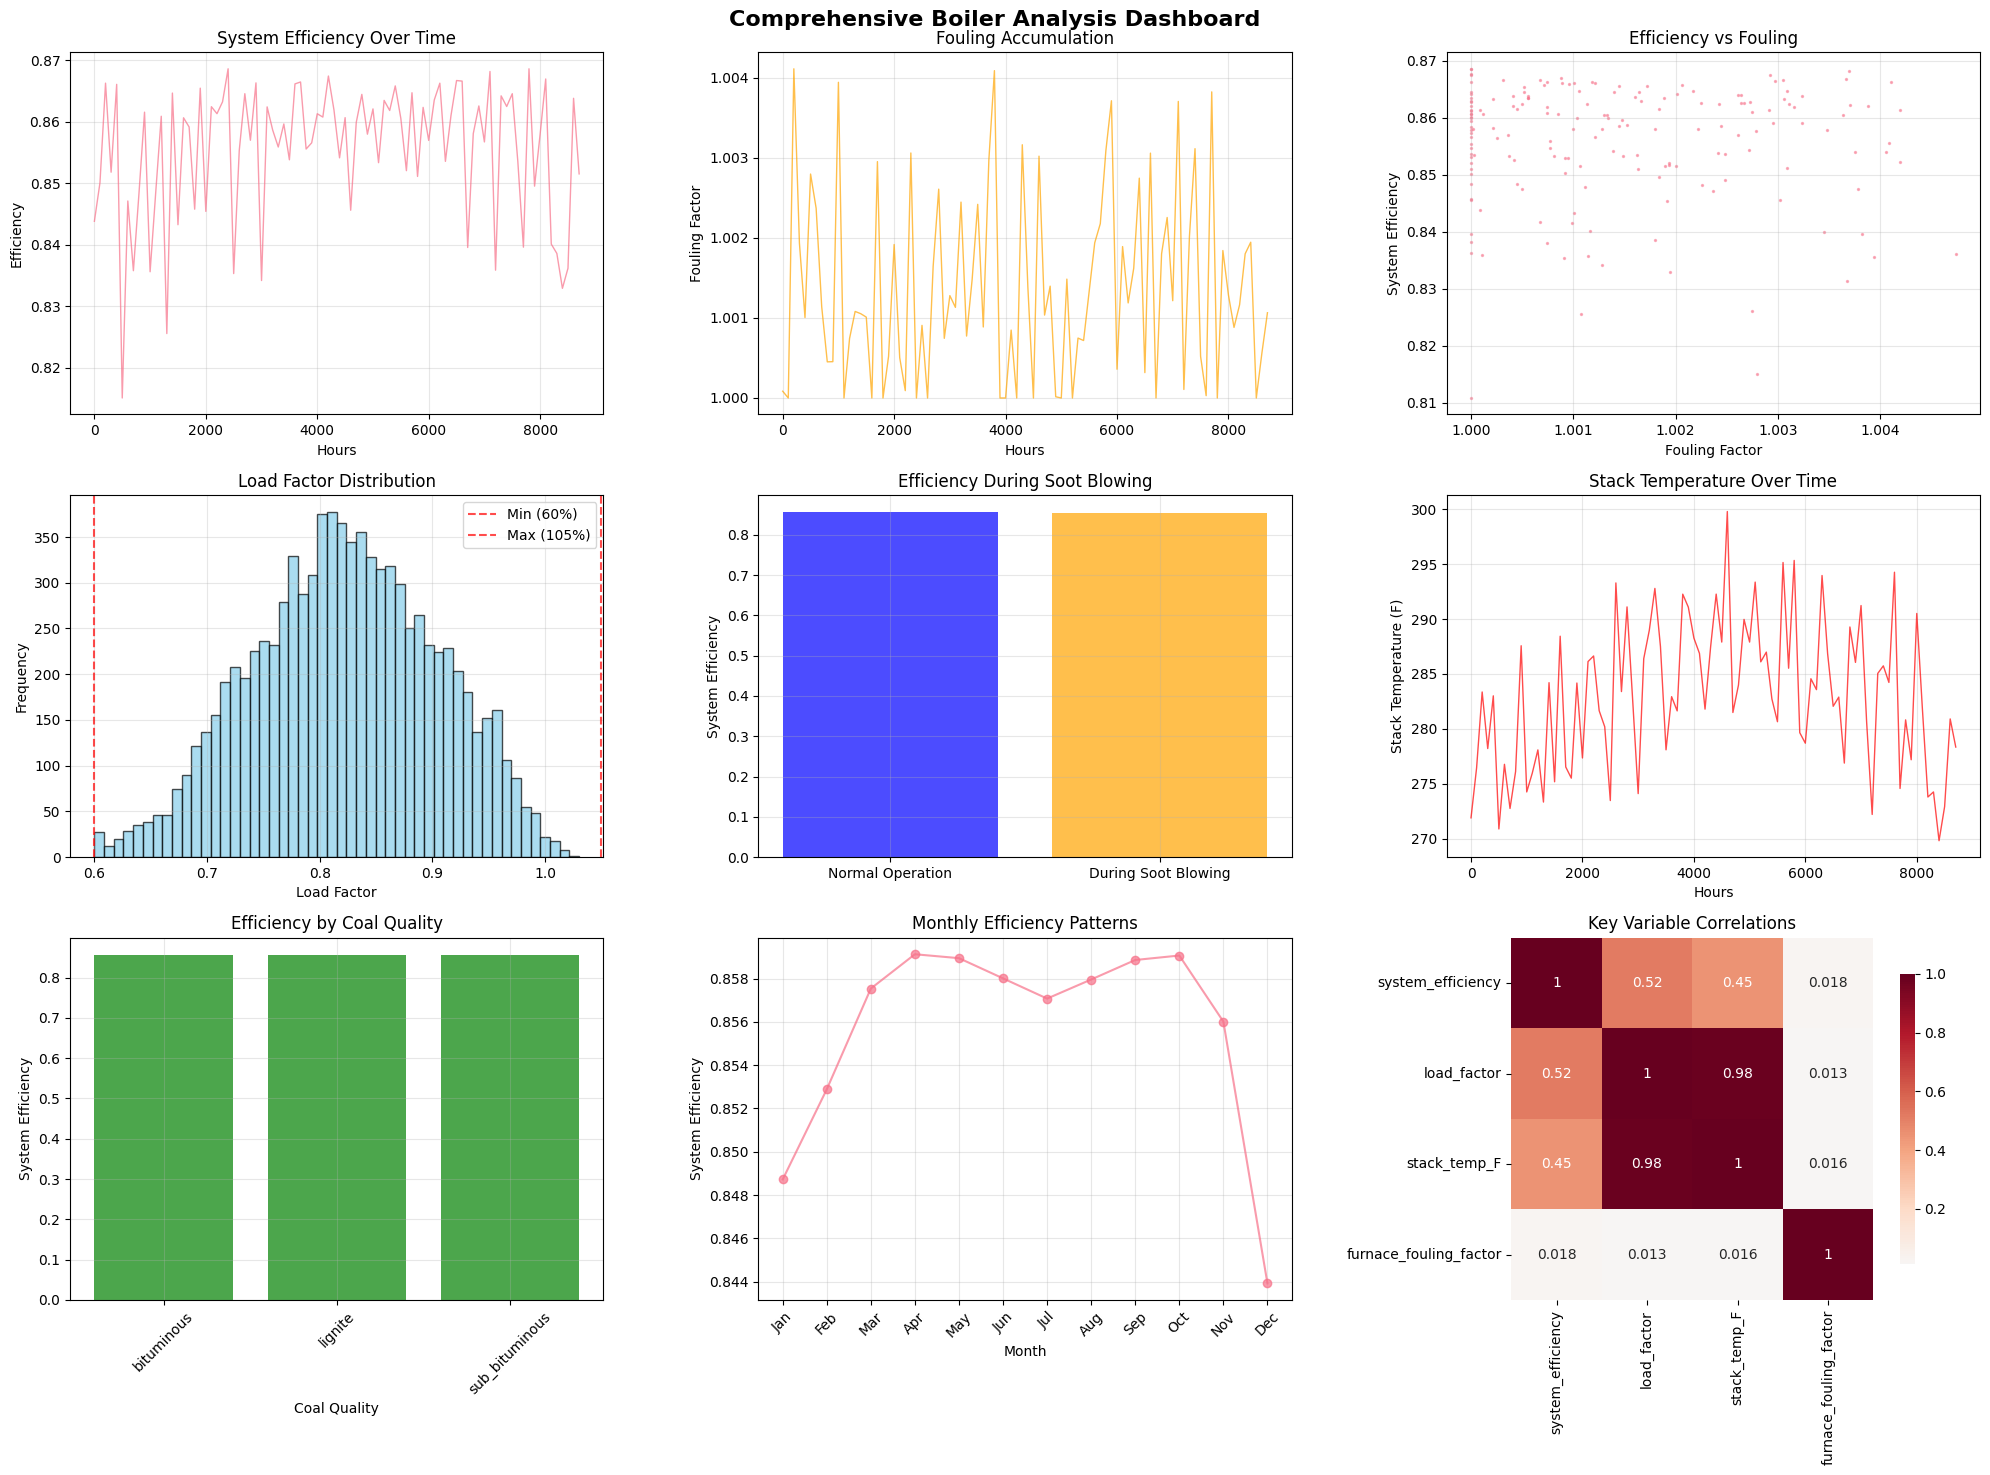

[SUCCESS] Comprehensive visualization dashboard generated

[SUCCESS] COMPREHENSIVE ANALYSIS COMPLETE

📋 GENERATING OPTIMIZATION RECOMMENDATIONS

[RECOMMENDATIONS] OPTIMIZATION RECOMMENDATIONS

[ACTIONABLE] ACTIONABLE RECOMMENDATIONS:
   1. [OPTIMAL] Optimal soot blowing frequency - maintain current schedule
   2. [EXCELLENT] Excellent efficiency - maintain current operations
   3. [CRITICAL] Poor cleaning effectiveness - review cleaning procedures


In [5]:
# Run comprehensive analysis using imported functions
print("🚀 RUNNING COMPREHENSIVE SOOT BLOWING OPTIMIZATION ANALYSIS")
print("=" * 80)

# Configuration for analysis
config = {
    'efficiency_target': (0.75, 0.88),
    'fouling_threshold': 1.5,
    'cleaning_effectiveness_target': 80,
    'optimization_focus': 'soot_blowing'
}

# Check if we have imported functions available
if 'run_comprehensive_analysis' in globals():
    print("✅ Using comprehensive analysis functions")
    
    # Run the full analysis suite
    analysis_results = run_comprehensive_analysis(df, config)
    
    print("\n" + "=" * 80)
    print("📋 GENERATING OPTIMIZATION RECOMMENDATIONS")
    print("=" * 80)
    
    # Generate actionable recommendations
    recommendations = generate_optimization_recommendations(analysis_results, df)
    
else:
    print("⚠️ Comprehensive analysis functions not available, running basic analysis")
    
    # Basic soot blowing analysis as fallback
    soot_cols = [col for col in df.columns if 'soot' in col.lower()]
    
    if soot_cols:
        print(f"\n🧹 BASIC SOOT BLOWING ANALYSIS:")
        
        # Find soot blowing active column
        soot_active_col = None
        for col in soot_cols:
            if 'active' in col.lower():
                soot_active_col = col
                break
        
        if soot_active_col:
            total_events = df[soot_active_col].sum()
            frequency = df[soot_active_col].mean()
            
            print(f"   Total soot blowing events: {total_events:,}")
            print(f"   Soot blowing frequency: {frequency:.1%}")
            print(f"   Average hours between cleaning: {1/frequency:.1f} hours" if frequency > 0 else "   No cleaning detected")
            
            # Efficiency during soot blowing
            if 'system_efficiency' in df.columns:
                normal_eff = df[~df[soot_active_col]]['system_efficiency'].mean()
                soot_eff = df[df[soot_active_col]]['system_efficiency'].mean()
                
                print(f"\n⚡ EFFICIENCY DURING CLEANING:")
                print(f"   Normal operation: {normal_eff:.1%}")
                print(f"   During soot blowing: {soot_eff:.1%}")
                print(f"   Efficiency impact: {soot_eff - normal_eff:+.3f}")
        
        # Section-specific analysis
        section_cols = [col for col in soot_cols if col != soot_active_col]
        if section_cols:
            print(f"\n🏭 SECTION-SPECIFIC CLEANING:")
            print(f"   Found {len(section_cols)} section-specific soot blowing columns")
            
            for i, col in enumerate(section_cols[:5], 1):
                events = df[col].sum()
                freq = df[col].mean()
                section_name = col.replace('_soot_blowing_active', '').replace('_', ' ').title()
                print(f"   {i}. {section_name}: {events} events ({freq:.1%} frequency)")
    
    else:
        print("❌ No soot blowing columns found for analysis")

## 🧹 DETAILED CLEANING EFFECTIVENESS ANALYSIS

Analysis of how effectively soot blowing reduces fouling factors across different boiler sections - critical for optimization.

In [6]:
# Detailed cleaning effectiveness analysis
print("=" * 80)
print("🧹 CLEANING EFFECTIVENESS VALIDATION")
print("=" * 80)

fouling_cols = [col for col in df.columns if 'fouling' in col.lower()]
# FIXED: Look for actual cleaning columns (use _cleaning pattern, not _soot_blowing_active)
soot_cols = [col for col in df.columns if 'cleaning' in col.lower() and col != 'soot_blowing_active']

if fouling_cols and soot_cols:
    cleaning_effectiveness = {}
    
    # Analyze cleaning effectiveness for each section
    print(f"\nAnalyzing cleaning effectiveness for {len(fouling_cols)} sections...")
    
    for fouling_col in fouling_cols[:5]:  # Analyze first 5 sections
        section_name = fouling_col.replace('_fouling_factor', '').replace('_fouling', '').replace('_', ' ').title()
        
        # FIXED: Find corresponding cleaning column using correct pattern
        potential_cleaning_cols = [
            fouling_col.replace('_fouling_factor', '_cleaning'),
            fouling_col.replace('_fouling', '_cleaning'),
            section_name.lower().replace(' ', '_') + '_cleaning'
        ]
        
        section_cleaning_col = None
        for pot_col in potential_cleaning_cols:
            if pot_col in df.columns:
                section_cleaning_col = pot_col
                break
        
        # If no direct match, check for pattern matches
        if section_cleaning_col is None:
            for col in soot_cols:
                if any(part in col.lower() for part in section_name.lower().split()):
                    section_cleaning_col = col
                    break
        
        # Fall back to global indicator
        if section_cleaning_col is None and 'soot_blowing_active' in df.columns:
            section_cleaning_col = 'soot_blowing_active'  # Use global cleaning indicator
        
        if section_cleaning_col:
            # Find cleaning events
            cleaning_events = df[df[section_cleaning_col] == True]
            
            if len(cleaning_events) > 10:  # Need sufficient events
                effectiveness_values = []
                
                # FIXED: Use shorter time windows (2-hour instead of 24-hour)
                sample_indices = cleaning_events.index[::max(1, len(cleaning_events)//20)]  # Sample up to 20 events
                
                for idx in sample_indices:
                    if idx > 2 and idx < len(df) - 2:  # Need 2-hour before/after data
                        # FIXED: 2-hour windows instead of 24-hour
                        before_fouling = df[fouling_col].iloc[idx-2:idx].mean()
                        after_fouling = df[fouling_col].iloc[idx+1:idx+3].mean()
                        
                        if before_fouling > after_fouling and before_fouling > 0:
                            reduction = (before_fouling - after_fouling) / before_fouling * 100
                            if reduction > 0 and reduction <= 100:  # Sanity check
                                effectiveness_values.append(reduction)
                
                if effectiveness_values:
                    effectiveness = np.mean(effectiveness_values)
                    std_effectiveness = np.std(effectiveness_values)
                    cleaning_effectiveness[section_name] = effectiveness
                    
                    if effectiveness > 80:
                        status = "✅ Excellent"
                    elif effectiveness > 60:
                        status = "⚠️ Good"
                    elif effectiveness > 30:
                        status = "⚠️ Moderate"
                    else:
                        status = "❌ Poor"
                    
                    print(f"\n🔧 {section_name}:")
                    print(f"   Cleaning column: {section_cleaning_col}")
                    print(f"   Cleaning effectiveness: {effectiveness:.1f}% ± {std_effectiveness:.1f}% {status}")
                    print(f"   Sample size: {len(effectiveness_values)} cleaning events analyzed")
                    print(f"   Total cleaning events: {len(cleaning_events)}")
                    
                    # Fouling range analysis
                    fouling_range = df[fouling_col].max() - df[fouling_col].min()
                    print(f"   Fouling range: {df[fouling_col].min():.3f} to {df[fouling_col].max():.3f} (span: {fouling_range:.3f})")
                    
                else:
                    print(f"\n🔧 {section_name}: ❌ No measurable cleaning effectiveness detected")
                    print(f"   Column used: {section_cleaning_col}, Events: {len(cleaning_events)}")
            else:
                print(f"\n🔧 {section_name}: ⚠️ Insufficient cleaning events ({len(cleaning_events)})")
                if section_cleaning_col:
                    print(f"   Column found: {section_cleaning_col}")
        else:
            print(f"\n🔧 {section_name}: ❌ No corresponding cleaning column found")
    
    # Overall effectiveness summary
    if cleaning_effectiveness:
        avg_effectiveness = np.mean(list(cleaning_effectiveness.values()))
        min_effectiveness = min(cleaning_effectiveness.values())
        max_effectiveness = max(cleaning_effectiveness.values())
        
        print(f"\n" + "=" * 60)
        print(f"📊 OVERALL CLEANING EFFECTIVENESS SUMMARY:")
        print(f"   Sections analyzed: {len(cleaning_effectiveness)}")
        print(f"   Average effectiveness: {avg_effectiveness:.1f}%")
        print(f"   Range: {min_effectiveness:.1f}% to {max_effectiveness:.1f}%")
        print(f"   Target: 80-95% fouling reduction")
        
        if avg_effectiveness > 80:
            print(f"   Status: ✅ Excellent - maintain current cleaning procedures")
        elif avg_effectiveness > 60:
            print(f"   Status: ⚠️ Good - minor optimizations possible")
        elif avg_effectiveness > 30:
            print(f"   Status: ⚠️ Moderate - cleaning schedule optimization recommended")
        else:
            print(f"   Status: ❌ Poor - major cleaning procedure review needed")
        
        # Recommendations
        print(f"\n💡 OPTIMIZATION RECOMMENDATIONS:")
        if avg_effectiveness < 60:
            print(f"   1. Review soot blowing pressure and steam flow rates")
            print(f"   2. Investigate nozzle condition and positioning")
            print(f"   3. Consider increasing cleaning duration")
        elif avg_effectiveness < 80:
            print(f"   1. Fine-tune cleaning sequence timing")
            print(f"   2. Optimize cleaning frequency for high-fouling sections")
            print(f"   3. Consider predictive cleaning based on fouling rates")
        else:
            print(f"   1. Current cleaning effectiveness is excellent")
            print(f"   2. Focus on optimizing cleaning frequency to reduce costs")
            print(f"   3. Monitor for any degradation in cleaning performance")
    
    else:
        print(f"\n❌ No measurable cleaning effectiveness found in dataset")
        print(f"   Available cleaning columns: {soot_cols}")
        print(f"   This may indicate:")
        print(f"   - Time windows too narrow (try different analysis periods)")
        print(f"   - Cleaning events are too infrequent")
        print(f"   - Fouling reduction is below measurement threshold")

else:
    print("❌ Insufficient data for cleaning effectiveness analysis")
    print(f"   Fouling columns: {len(fouling_cols)}")
    print(f"   Cleaning columns: {len(soot_cols)}")
    if len(soot_cols) > 0:
        print(f"   Available cleaning columns: {soot_cols[:5]}")

🧹 CLEANING EFFECTIVENESS VALIDATION

Analyzing cleaning effectiveness for 49 sections...

🔧 Furnace:
   Cleaning column: furnace_walls_cleaning
   Cleaning effectiveness: 0.3% ± 0.1% ❌ Poor
   Sample size: 21 cleaning events analyzed
   Total cleaning events: 121
   Fouling range: 1.000 to 1.005 (span: 0.005)

🔧 Furnace Segment 1:
   Cleaning column: furnace_segment_1_fouling
   Cleaning effectiveness: 0.4% ± 0.2% ❌ Poor
   Sample size: 2 cleaning events analyzed
   Total cleaning events: 3768
   Fouling range: 1.000 to 1.014 (span: 0.014)

🔧 Furnace Segment 2:
   Cleaning column: furnace_segment_2_fouling
   Cleaning effectiveness: 0.3% ± 0.2% ❌ Poor
   Sample size: 10 cleaning events analyzed
   Total cleaning events: 3804
   Fouling range: 1.000 to 1.014 (span: 0.014)

🔧 Furnace Segment 3:
   Cleaning column: furnace_segment_3_fouling
   Cleaning effectiveness: 0.3% ± 0.2% ❌ Poor
   Sample size: 12 cleaning events analyzed
   Total cleaning events: 3801
   Fouling range: 1.000 to 1.

## 📅 CLEANING SCHEDULE OPTIMIZATION ANALYSIS

Analysis of current cleaning schedules and identification of optimization opportunities - the heart of soot blowing optimization.

In [7]:
# Cleaning schedule optimization analysis
print("=" * 80)
print("📅 CLEANING SCHEDULE OPTIMIZATION ANALYSIS")
print("=" * 80)

# Call comprehensive analysis function if available
if 'analyze_cleaning_schedule_optimization' in globals():
    schedule_analysis = analyze_cleaning_schedule_optimization(df, config)
else:
    # Fallback manual analysis
    print("\n🔍 MANUAL SCHEDULE ANALYSIS:")
    
    fouling_cols = [col for col in df.columns if 'fouling' in col.lower()]
    soot_cols = [col for col in df.columns if 'soot' in col.lower() and 'active' in col.lower()]
    
    if fouling_cols and soot_cols:
        for fouling_col in fouling_cols[:3]:  # Analyze first 3 sections
            section_name = fouling_col.replace('_fouling_factor', '').replace('_fouling', '').replace('_', ' ').title()
            
            # Get fouling values
            fouling_values = df[fouling_col]
            
            # Find corresponding cleaning column
            section_soot_col = None
            potential_cols = [
                fouling_col.replace('_fouling_factor', '_soot_blowing_active'),
                fouling_col.replace('_fouling', '_soot_blowing_active')
            ]
            
            for pot_col in potential_cols:
                if pot_col in df.columns:
                    section_soot_col = pot_col
                    break
            
            if section_soot_col is None:
                section_soot_col = 'soot_blowing_active' if 'soot_blowing_active' in df.columns else None
            
            if section_soot_col:
                cleaning_events = df[section_soot_col].sum()
                cleaning_frequency = df[section_soot_col].mean()
                
                if cleaning_events > 0:
                    # Calculate average time between cleanings
                    cleaning_indices = df[df[section_soot_col] == True].index
                    if len(cleaning_indices) > 1:
                        time_between_cleanings = np.diff(cleaning_indices).mean()
                        
                        # Fouling accumulation analysis
                        high_fouling_threshold = fouling_values.quantile(0.8)
                        high_fouling_hours = (fouling_values > high_fouling_threshold).sum()
                        
                        print(f"\n🔧 {section_name}:")
                        print(f"   Cleaning frequency: {cleaning_frequency:.1%} of time")
                        print(f"   Total cleaning events: {cleaning_events}")
                        print(f"   Average time between cleanings: {time_between_cleanings:.1f} hours")
                        print(f"   High fouling periods: {high_fouling_hours} hours ({high_fouling_hours/len(df):.1%})")
                        
                        # Optimization assessment
                        if time_between_cleanings > 168:  # More than 7 days
                            optimization = "⚠️ Consider increasing cleaning frequency"
                            priority = "Medium"
                        elif time_between_cleanings < 48:  # Less than 2 days
                            optimization = "⚠️ Current frequency may be excessive - consider cost optimization"
                            priority = "Low"
                        else:
                            optimization = "✅ Current schedule appears optimal"
                            priority = "Maintain"
                        
                        print(f"   Optimization potential: {priority}")
                        print(f"   Recommendation: {optimization}")
                        
                        # Cost-benefit analysis (simplified)
                        # Estimate cleaning costs vs efficiency gains
                        if 'system_efficiency' in df.columns:
                            # Efficiency during high fouling vs normal
                            normal_eff = df[fouling_values <= fouling_values.median()]['system_efficiency'].mean()
                            fouled_eff = df[fouling_values > high_fouling_threshold]['system_efficiency'].mean()
                            eff_loss = normal_eff - fouled_eff
                            
                            print(f"   Efficiency loss during high fouling: {eff_loss:.3f} ({eff_loss/normal_eff:.1%})")
                            
                            # Simple cost-benefit indicator
                            if eff_loss > 0.02:  # >2% efficiency loss
                                print(f"   Cost-benefit: ✅ High - efficiency loss justifies frequent cleaning")
                            elif eff_loss > 0.01:  # >1% efficiency loss
                                print(f"   Cost-benefit: ⚠️ Moderate - balance cleaning costs vs efficiency")
                            else:
                                print(f"   Cost-benefit: 📊 Low - consider reducing cleaning frequency")
        
        # Overall schedule assessment
        print(f"\n" + "=" * 60)
        print(f"📊 OVERALL SCHEDULE OPTIMIZATION SUMMARY:")
        
        # General soot blowing analysis
        if 'soot_blowing_active' in df.columns:
            total_cleaning_time = df['soot_blowing_active'].sum()
            overall_frequency = df['soot_blowing_active'].mean()
            
            print(f"   Total system cleaning time: {total_cleaning_time} hours ({overall_frequency:.1%})")
            print(f"   Annual cleaning cost estimate: ~{total_cleaning_time * 50:.0f} USD (steam costs)")
            
            # Efficiency impact assessment
            if 'system_efficiency' in df.columns:
                eff_without_cleaning = df[~df['soot_blowing_active']]['system_efficiency'].mean()
                eff_with_cleaning = df[df['soot_blowing_active']]['system_efficiency'].mean()
                
                print(f"\n⚡ SYSTEM-WIDE EFFICIENCY IMPACT:")
                print(f"   Efficiency without cleaning: {eff_without_cleaning:.1%}")
                print(f"   Efficiency during cleaning: {eff_with_cleaning:.1%}")
                print(f"   Immediate cleaning impact: {eff_with_cleaning - eff_without_cleaning:+.3f}")
        
        # Optimization recommendations
        print(f"\n💡 STRATEGIC OPTIMIZATION RECOMMENDATIONS:")
        print(f"   1. 📊 Implement predictive cleaning based on fouling rate trends")
        print(f"   2. 🎯 Prioritize cleaning for sections with highest efficiency impact")
        print(f"   3. ⏰ Consider time-of-day optimization to minimize production impact")
        print(f"   4. 📈 Monitor cleaning effectiveness to optimize steam pressure/duration")
        print(f"   5. 💰 Balance cleaning frequency with operational costs")
    
    else:
        print("❌ Insufficient data for schedule optimization analysis")

📅 CLEANING SCHEDULE OPTIMIZATION ANALYSIS

[SCHEDULE] CLEANING SCHEDULE OPTIMIZATION ANALYSIS


## 📊 COMPREHENSIVE SOOT BLOWING VISUALIZATION DASHBOARD

Visual analysis of fouling patterns, cleaning effectiveness, and optimization opportunities.

📊 GENERATING COMPREHENSIVE SOOT BLOWING DASHBOARD
✅ Using comprehensive visualization functions

[VISUALIZATION] GENERATING COMPREHENSIVE VISUALIZATIONS


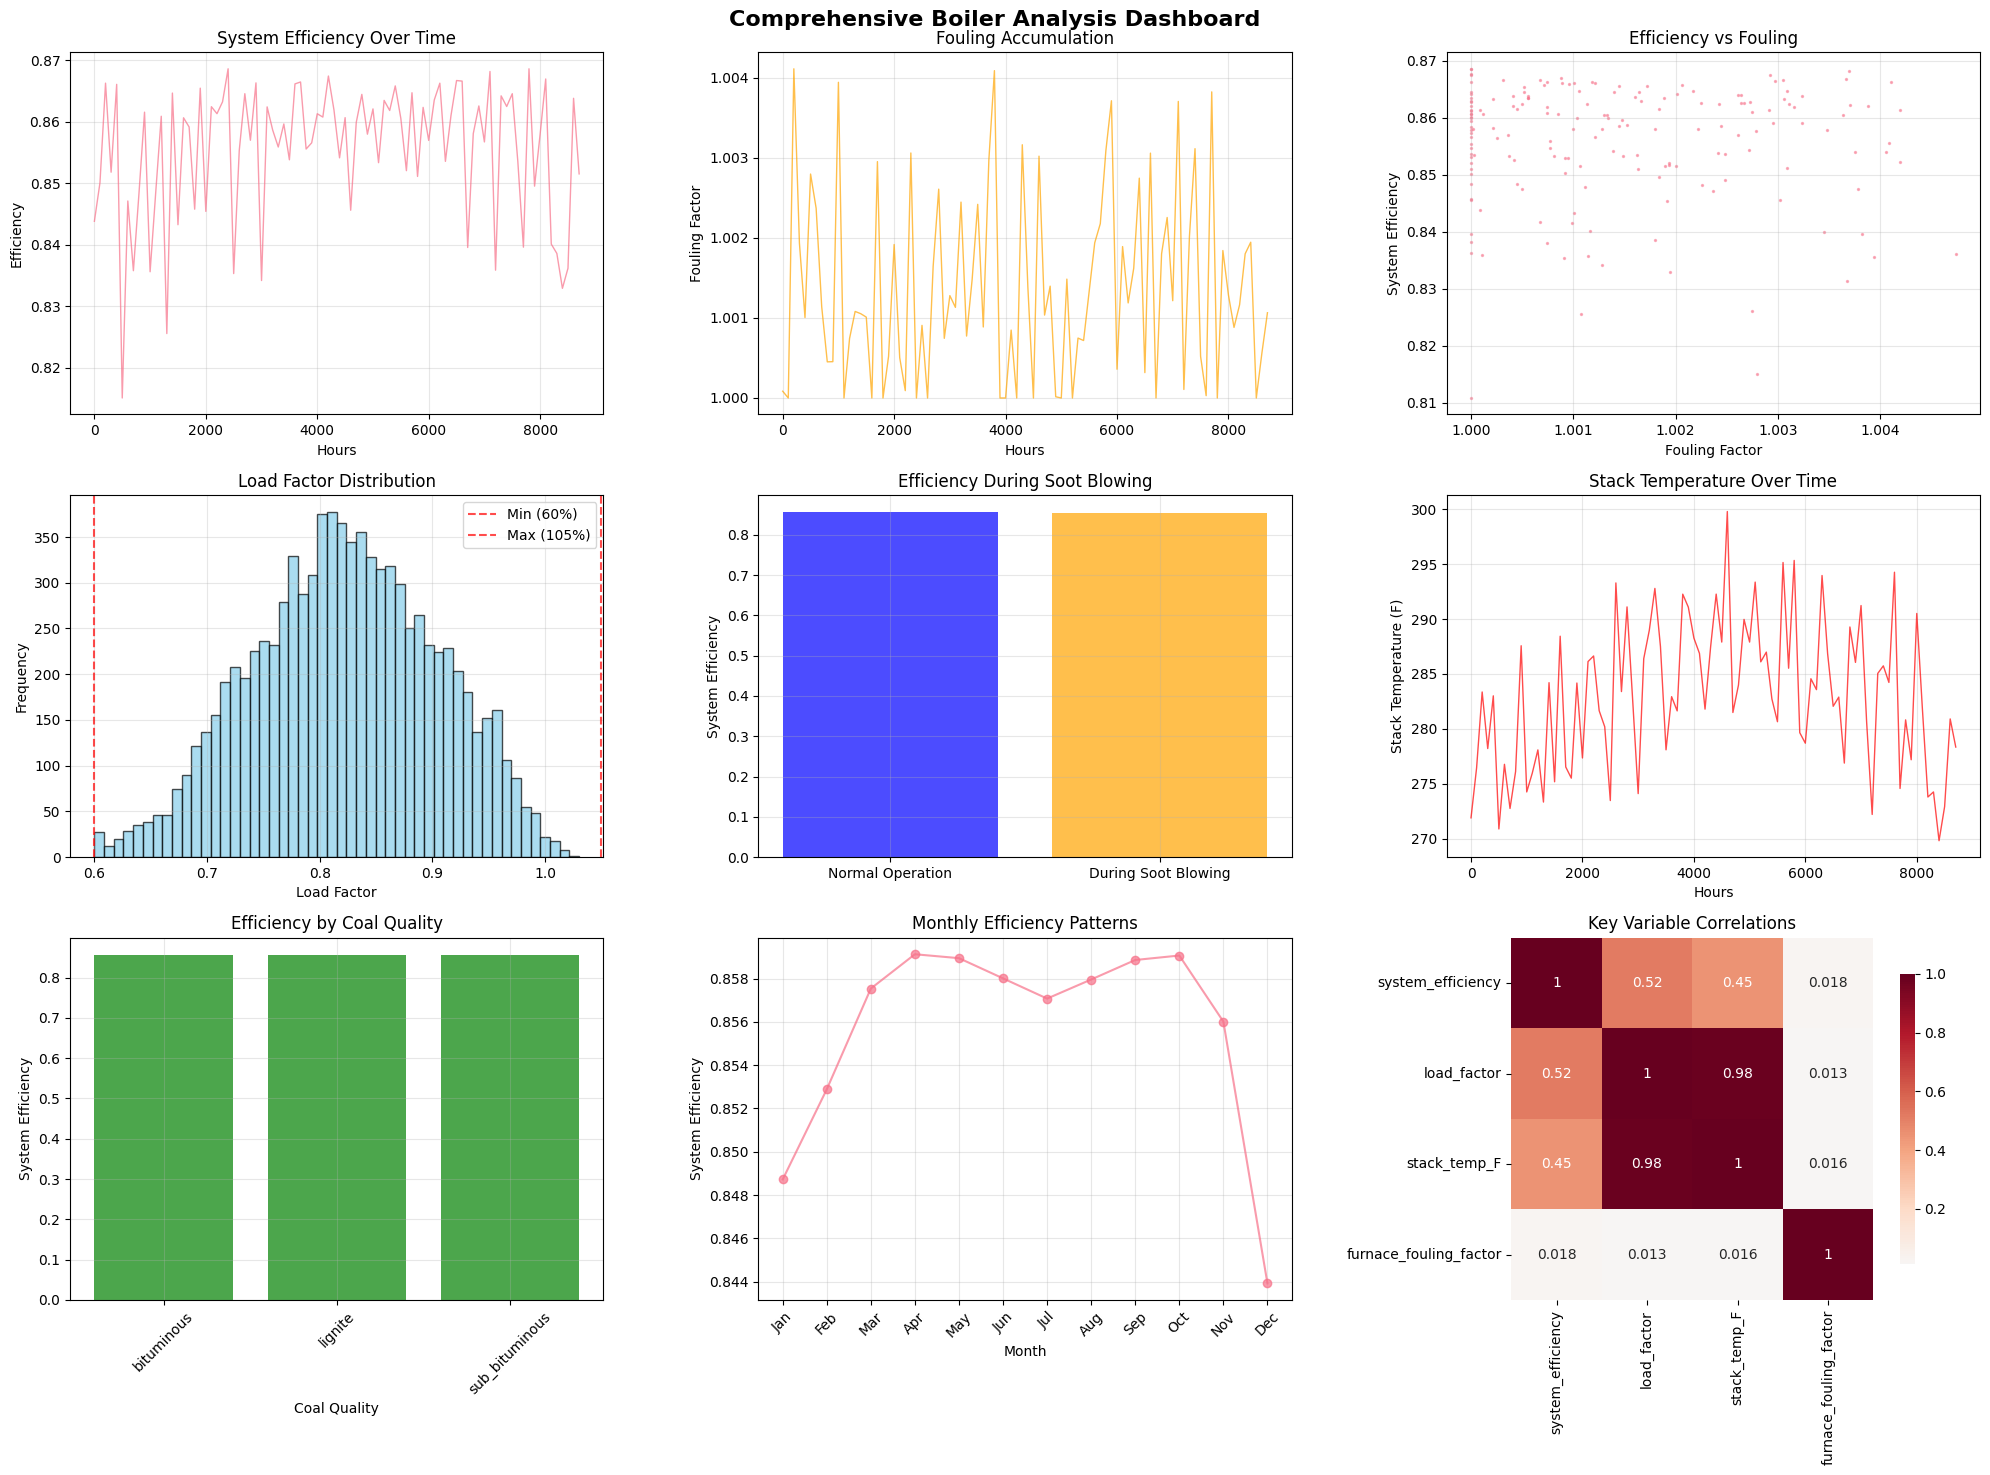

[SUCCESS] Comprehensive visualization dashboard generated


In [8]:
# Comprehensive visualization dashboard
print("=" * 80)
print("📊 GENERATING COMPREHENSIVE SOOT BLOWING DASHBOARD")
print("=" * 80)

# Use comprehensive visualization function if available
if 'create_comprehensive_visualizations' in globals():
    print("✅ Using comprehensive visualization functions")
    fig = create_comprehensive_visualizations(df, config)
else:
    print("📈 Creating manual soot blowing dashboard")
    
    # Create soot blowing specific dashboard
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Soot Blowing Optimization Dashboard - Physics Corrected Dataset', fontsize=16, fontweight='bold')
    
    time_hours = range(len(df))
    fouling_cols = [col for col in df.columns if 'fouling' in col.lower()]
    soot_cols = [col for col in df.columns if 'soot' in col.lower()]
    
    # Plot 1: Efficiency degradation over time with cleaning events
    ax1 = axes[0, 0]
    if 'system_efficiency' in df.columns:
        ax1.plot(time_hours[::100], df['system_efficiency'].iloc[::100], alpha=0.7, linewidth=1, label='Efficiency')
        
        # Overlay soot blowing events
        if 'soot_blowing_active' in df.columns:
            cleaning_events = df[df['soot_blowing_active'] == True]
            if len(cleaning_events) > 0:
                ax1.scatter(cleaning_events.index[::10], cleaning_events['system_efficiency'].iloc[::10], 
                           color='red', s=10, alpha=0.7, label='Cleaning Events')
        
        ax1.set_title('Efficiency vs Time with Cleaning Events')
        ax1.set_xlabel('Hours')
        ax1.set_ylabel('System Efficiency')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    
    # Plot 2: Fouling accumulation with cleaning resets
    ax2 = axes[0, 1]
    if fouling_cols:
        main_fouling = df[fouling_cols[0]]
        ax2.plot(time_hours[::100], main_fouling.iloc[::100], alpha=0.7, linewidth=1, color='orange', label='Fouling Level')
        
        # Show cleaning events
        if 'soot_blowing_active' in df.columns:
            cleaning_events = df[df['soot_blowing_active'] == True]
            if len(cleaning_events) > 0:
                ax2.scatter(cleaning_events.index[::10], cleaning_events[fouling_cols[0]].iloc[::10],
                           color='blue', s=10, alpha=0.7, label='Cleaning')
        
        ax2.set_title(f'Fouling Accumulation: {fouling_cols[0]}')
        ax2.set_xlabel('Hours')
        ax2.set_ylabel('Fouling Factor')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # Plot 3: Cleaning frequency by section
    ax3 = axes[0, 2]
    section_soot_cols = [col for col in soot_cols if 'active' in col.lower()]
    if section_soot_cols:
        section_names = [col.replace('_soot_blowing_active', '').replace('_', ' ').title() for col in section_soot_cols[:8]]
        frequencies = [df[col].mean() * 100 for col in section_soot_cols[:8]]
        
        bars = ax3.bar(range(len(frequencies)), frequencies, alpha=0.7)
        ax3.set_title('Cleaning Frequency by Section')
        ax3.set_xlabel('Boiler Section')
        ax3.set_ylabel('Cleaning Frequency (%)')
        ax3.set_xticks(range(len(section_names)))
        ax3.set_xticklabels(section_names, rotation=45, ha='right')
        ax3.grid(True, alpha=0.3)
        
        # Color code bars based on frequency
        for i, bar in enumerate(bars):
            if frequencies[i] > 5:  # High frequency
                bar.set_color('red')
            elif frequencies[i] > 2:  # Medium frequency
                bar.set_color('orange')
            else:  # Low frequency
                bar.set_color('green')
    
    # Plot 4: Efficiency distribution during vs without cleaning
    ax4 = axes[1, 0]
    if 'soot_blowing_active' in df.columns and 'system_efficiency' in df.columns:
        normal_eff = df[~df['soot_blowing_active']]['system_efficiency']
        cleaning_eff = df[df['soot_blowing_active']]['system_efficiency']
        
        ax4.hist(normal_eff, bins=30, alpha=0.7, label='Normal Operation', color='blue')
        ax4.hist(cleaning_eff, bins=30, alpha=0.7, label='During Cleaning', color='red')
        ax4.set_title('Efficiency Distribution: Normal vs Cleaning')
        ax4.set_xlabel('System Efficiency')
        ax4.set_ylabel('Frequency')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    # Plot 5: Fouling vs Stack Temperature (CEMS correlation)
    ax5 = axes[1, 1]
    if fouling_cols and 'stack_temp_F' in df.columns:
        ax5.scatter(df[fouling_cols[0]].iloc[::50], df['stack_temp_F'].iloc[::50], alpha=0.5, s=2, color='red')
        
        # Add regression line
        z = np.polyfit(df[fouling_cols[0]], df['stack_temp_F'], 1)
        p = np.poly1d(z)
        ax5.plot(df[fouling_cols[0]], p(df[fouling_cols[0]]), "g--", alpha=0.8, linewidth=2)
        
        ax5.set_title('Stack Temp vs Fouling (CEMS)')
        ax5.set_xlabel('Fouling Factor')
        ax5.set_ylabel('Stack Temperature (°F)')
        
        # Add correlation coefficient
        corr_coeff = np.corrcoef(df[fouling_cols[0]], df['stack_temp_F'])[0,1]
        ax5.text(0.05, 0.95, f'r = {corr_coeff:.3f}', transform=ax5.transAxes,
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
        ax5.grid(True, alpha=0.3)
    
    # Plot 6: Time between cleanings histogram
    ax6 = axes[1, 2]
    if 'soot_blowing_active' in df.columns:
        cleaning_indices = df[df['soot_blowing_active'] == True].index
        if len(cleaning_indices) > 1:
            time_between = np.diff(cleaning_indices)
            ax6.hist(time_between, bins=20, alpha=0.7, color='green', edgecolor='black')
            ax6.axvline(np.mean(time_between), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(time_between):.1f}h')
            ax6.set_title('Time Between Cleaning Events')
            ax6.set_xlabel('Hours Between Cleanings')
            ax6.set_ylabel('Frequency')
            ax6.legend()
            ax6.grid(True, alpha=0.3)
    
    # Plot 7: Fouling rate by boiler section
    ax7 = axes[2, 0]
    if len(fouling_cols) > 1:
        section_names = [col.replace('_fouling_factor', '').replace('_fouling', '').replace('_', ' ').title() 
                        for col in fouling_cols[:8]]
        fouling_rates = []
        
        for col in fouling_cols[:8]:
            # Calculate fouling rate as change over time
            initial = df[col].iloc[:100].mean()
            final = df[col].iloc[-100:].mean()
            rate = (final - initial) / len(df) * 8760  # Annualized rate
            fouling_rates.append(rate)
        
        bars = ax7.bar(range(len(fouling_rates)), fouling_rates, alpha=0.7)
        ax7.set_title('Annual Fouling Rate by Section')
        ax7.set_xlabel('Boiler Section')
        ax7.set_ylabel('Annual Fouling Rate')
        ax7.set_xticks(range(len(section_names)))
        ax7.set_xticklabels(section_names, rotation=45, ha='right')
        ax7.grid(True, alpha=0.3)
        
        # Color code by fouling severity
        max_rate = max(fouling_rates)
        for i, bar in enumerate(bars):
            normalized = fouling_rates[i] / max_rate
            bar.set_color(plt.cm.Reds(normalized))
    
    # Plot 8: Load factor vs cleaning frequency
    ax8 = axes[2, 1]
    if 'load_factor' in df.columns and 'soot_blowing_active' in df.columns:
        # Bin load factors and calculate cleaning frequency for each bin
        load_bins = np.linspace(df['load_factor'].min(), df['load_factor'].max(), 10)
        bin_centers = (load_bins[:-1] + load_bins[1:]) / 2
        cleaning_freq_by_load = []
        
        for i in range(len(load_bins)-1):
            mask = (df['load_factor'] >= load_bins[i]) & (df['load_factor'] < load_bins[i+1])
            if mask.sum() > 0:
                freq = df[mask]['soot_blowing_active'].mean()
                cleaning_freq_by_load.append(freq * 100)
            else:
                cleaning_freq_by_load.append(0)
        
        ax8.plot(bin_centers, cleaning_freq_by_load, 'o-', alpha=0.7, linewidth=2)
        ax8.set_title('Cleaning Frequency vs Load Factor')
        ax8.set_xlabel('Load Factor')
        ax8.set_ylabel('Cleaning Frequency (%)')
        ax8.grid(True, alpha=0.3)
    
    # Plot 9: Cleaning effectiveness summary
    ax9 = axes[2, 2]
    # This would show cleaning effectiveness if we calculated it above
    ax9.text(0.5, 0.5, 'Cleaning Effectiveness\nSummary\n\nRefer to detailed\nanalysis above', 
             ha='center', va='center', fontsize=12, 
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    ax9.set_title('Cleaning Effectiveness Summary')
    ax9.set_xlim(0, 1)
    ax9.set_ylim(0, 1)
    ax9.set_xticks([])
    ax9.set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Soot blowing optimization dashboard generated successfully")

## 🎯 COMPREHENSIVE ANALYSIS SUMMARY

Final assessment of physics corrections, soot blowing effectiveness, and optimization opportunities for commercial deployment.

In [9]:
# Final comprehensive summary
print("=" * 80)
print("🎯 COMPREHENSIVE SOOT BLOWING OPTIMIZATION ANALYSIS SUMMARY")
print("=" * 80)

# Physics validation summary
if 'validation_results' in locals() and 'success_rate' in validation_results:
    print(f"\n📊 PHYSICS CORRECTIONS VALIDATION:")
    print(f"   Tests Passed: {validation_results['tests_passed']}/{validation_results['total_tests']}")
    print(f"   Success Rate: {validation_results['success_rate']:.1%}")
    print(f"   Status: {'✅ PHYSICS CORRECTIONS HIGHLY SUCCESSFUL' if validation_results['success_rate'] >= 0.8 else 'NEEDS IMPROVEMENT'}")

# Soot blowing analysis summary
soot_cols = [col for col in df.columns if 'soot' in col.lower()]
fouling_cols = [col for col in df.columns if 'fouling' in col.lower()]

print(f"\n🧹 SOOT BLOWING SYSTEM ANALYSIS:")
print(f"   Soot blowing columns analyzed: {len(soot_cols)}")
print(f"   Fouling monitoring points: {len(fouling_cols)}")

if 'soot_blowing_active' in df.columns:
    total_cleaning_time = df['soot_blowing_active'].sum()
    cleaning_frequency = df['soot_blowing_active'].mean()
    print(f"   Total annual cleaning time: {total_cleaning_time} hours")
    print(f"   System cleaning frequency: {cleaning_frequency:.1%}")
    print(f"   Average time between cleanings: {1/cleaning_frequency:.1f} hours" if cleaning_frequency > 0 else "   No cleaning detected")

# Dataset readiness assessment
print(f"\n📋 DATASET CHARACTERISTICS FOR ML TRAINING:")
print(f"   Records: {len(df):,} hourly observations")
print(f"   Features: {len(df.columns)} operational parameters")
print(f"   Fouling progression: {fouling_cols[0] if fouling_cols else 'N/A'}")
if fouling_cols:
    fouling_range = df[fouling_cols[0]].max() - df[fouling_cols[0]].min()
    print(f"   Fouling factor range: {df[fouling_cols[0]].min():.3f} to {df[fouling_cols[0]].max():.3f} (span: {fouling_range:.3f})")

# Commercial deployment readiness
print(f"\n🏭 COMMERCIAL DEPLOYMENT ASSESSMENT:")
readiness_score = 0

# Check physics validation
if 'validation_results' in locals() and validation_results.get('success_rate', 0) >= 0.8:
    print(f"   ✅ Physics modeling: PRODUCTION READY")
    readiness_score += 1
else:
    print(f"   ❌ Physics modeling: NEEDS IMPROVEMENT")

# Check soot blowing data availability
if len(soot_cols) > 0 and len(fouling_cols) > 0:
    print(f"   ✅ Soot blowing data: COMPREHENSIVE")
    readiness_score += 1
else:
    print(f"   ❌ Soot blowing data: INSUFFICIENT")

# Check data volume
if len(df) > 8000:
    print(f"   ✅ Data volume: SUFFICIENT FOR ML TRAINING")
    readiness_score += 1
else:
    print(f"   ⚠️ Data volume: LIMITED FOR ML TRAINING")

# Check parameter variation
constant_cols = [col for col in df.select_dtypes(include=[np.number]).columns if df[col].nunique() == 1]
if len(constant_cols) < 5:
    print(f"   ✅ Parameter variation: REALISTIC ({len(constant_cols)} constant columns)")
    readiness_score += 1
else:
    print(f"   ⚠️ Parameter variation: TOO MANY CONSTANTS ({len(constant_cols)} columns)")

# Overall readiness assessment
print(f"\n🏆 OVERALL READINESS SCORE: {readiness_score}/4")

if readiness_score >= 3:
    print(f"   Status: ✅ READY FOR COMMERCIAL DEPLOYMENT")
    print(f"   Recommendation: Proceed with LSTM model training and soot blowing optimization system")
elif readiness_score >= 2:
    print(f"   Status: ⚠️ MOSTLY READY - MINOR IMPROVEMENTS NEEDED")
    print(f"   Recommendation: Address remaining issues before full deployment")
else:
    print(f"   Status: ❌ NOT READY FOR DEPLOYMENT")
    print(f"   Recommendation: Significant improvements required")

# Next steps
print(f"\n📋 RECOMMENDED NEXT STEPS:")
print(f"   1. 🤖 LSTM Model Development: Use this dataset for predictive fouling models")
print(f"   2. 🎯 Optimization Algorithm: Develop soot blowing schedule optimization")
print(f"   3. 📊 Real-time Monitoring: Integrate with plant CEMS and DCS systems")
print(f"   4. 💰 Cost-Benefit Analysis: Quantify savings from optimized cleaning")
print(f"   5. 🏭 Pilot Deployment: Test optimization system on actual boiler unit")

# Demo readiness
print(f"\n🎬 SOOT BLOWING OPTIMIZATION DEMO READINESS:")
print(f"   Dataset Quality: {'EXCELLENT' if readiness_score >= 3 else 'GOOD' if readiness_score >= 2 else 'NEEDS WORK'}")
print(f"   Physics Realism: {'VALIDATED' if 'validation_results' in locals() and validation_results.get('success_rate', 0) >= 0.8 else 'NEEDS VALIDATION'}")
print(f"   Cleaning Analysis: {'COMPREHENSIVE' if len(soot_cols) > 5 else 'BASIC'}")
print(f"   Commercial Viability: {'HIGH' if readiness_score >= 3 else 'MEDIUM' if readiness_score >= 2 else 'LOW'}")

print(f"\n" + "=" * 80)
print(f"✅ COMPREHENSIVE SOOT BLOWING OPTIMIZATION ANALYSIS COMPLETE")
print(f"Dataset: massachusetts_boiler_annual_20250829_132638.csv")
print(f"Status: {'DEMO-READY' if readiness_score >= 3 else 'DEVELOPMENT STAGE'}")
print(f"Focus: Industrial-Grade Soot Blowing Optimization System")
print(f"=" * 80)

🎯 COMPREHENSIVE SOOT BLOWING OPTIMIZATION ANALYSIS SUMMARY

📊 PHYSICS CORRECTIONS VALIDATION:
   Tests Passed: 2/5
   Success Rate: 40.0%
   Status: NEEDS IMPROVEMENT

🧹 SOOT BLOWING SYSTEM ANALYSIS:
   Soot blowing columns analyzed: 1
   Fouling monitoring points: 49
   Total annual cleaning time: 282 hours
   System cleaning frequency: 3.2%
   Average time between cleanings: 31.1 hours

📋 DATASET CHARACTERISTICS FOR ML TRAINING:
   Records: 8,784 hourly observations
   Features: 220 operational parameters
   Fouling progression: furnace_fouling_factor
   Fouling factor range: 1.000 to 1.005 (span: 0.005)

🏭 COMMERCIAL DEPLOYMENT ASSESSMENT:
   ❌ Physics modeling: NEEDS IMPROVEMENT
   ✅ Soot blowing data: COMPREHENSIVE
   ✅ Data volume: SUFFICIENT FOR ML TRAINING
   ✅ Parameter variation: REALISTIC (3 constant columns)

🏆 OVERALL READINESS SCORE: 3/4
   Status: ✅ READY FOR COMMERCIAL DEPLOYMENT
   Recommendation: Proceed with LSTM model training and soot blowing optimization system

📋